# Demand Forecasting Using NeuralProphet

This notebook demonstrates how a demand forecasting pipline can be created using NeuralProphet. 

### Use Case
We assume a single entity such as a SKU or product that is modeled separately from other entities. We assume that this entity is represented by a univariate time series such as revenue or sales volume data. We may or may not have additional covariate time series (regressors) which are known for both past and future time intervals. Our goal is to create a probabilistic forecast for the metric.

### Prototype: Approach and Data
We use the off-the-shelf Prophet/NeuralProphet functionality to create a reference forecasting pipeline. The pipeline includes data preparation, model training, and prediction steps.

### Usage and Productization
The prototype can be directly used to create basic forecasts for supply chain applications. Additional regressors can be straightforwardly added to the model inputs.

In [1]:
#
# Imports and settings
#
import numpy as np
import pandas as pd
from tabulate import tabulate

from neuralprophet import NeuralProphet

from matplotlib import pylab as plt
import matplotlib.dates as mdates
plt.style.use('seaborn-white')
pd.options.mode.chained_assignment = None
plt.rcParams.update({'pdf.fonttype': 'truetype'})

import platform
print(f'Python {platform.python_version()}')

Python 3.10.2


In [2]:
#
# Helper functions
#

# Print a dataset 
def print_df(df, rows = 10, print_df_mode='psql'):
    if print_df_mode == 'psql':
        print(tabulate(df.head(rows), headers='keys', tablefmt='psql'))
    else:
        display(df.head(rows))
    print(f'{len(df)} rows x {len(df.columns)} columns')
    
# Highlight weekends on a time series chart
def highlight_weekends(ax, color='k', alpha=0.1):
    ax.set_ylim(*ax.get_ylim())
    xmin, xmax = ax.get_xlim()
    days = np.arange(np.floor(xmin), np.ceil(xmax) + 2)
    weekends = [(dt.weekday()>=5)|(dt.weekday()==0) for dt in mdates.num2date(days)]
    ax.fill_between(days, *ax.get_ylim(), where=weekends, facecolor=color, alpha=alpha)
    ax.set_xlim(xmin, xmax)

# Data Loading

We use a small dataset that mimics daily sales series for a retail chain. The dataset consists of 500 sales time series for 10 stores and 50 items (SKUs). Each series spans 5 years.

In [3]:
data_path = '../../tensor-house-data/time-series'
df = pd.read_csv(f'{data_path}/store-item-sales.csv.zip', compression='zip', parse_dates=['date'], index_col='date')
df.sort_values(['date'], axis=0, ascending=[True], inplace=True)

print_df(df)
print(f'Unique stores: {df.store.nunique()}, unique items: {df.item.nunique()}')

+---------------------+---------+--------+---------+
| date                |   store |   item |   sales |
|---------------------+---------+--------+---------|
| 2013-01-01 00:00:00 |       1 |      1 |      13 |
| 2013-01-01 00:00:00 |       7 |     12 |      26 |
| 2013-01-01 00:00:00 |       7 |     46 |      27 |
| 2013-01-01 00:00:00 |       8 |     12 |      54 |
| 2013-01-01 00:00:00 |       9 |     12 |      35 |
| 2013-01-01 00:00:00 |      10 |     12 |      41 |
| 2013-01-01 00:00:00 |       6 |     46 |      23 |
| 2013-01-01 00:00:00 |       1 |     13 |      37 |
| 2013-01-01 00:00:00 |       2 |     13 |      51 |
| 2013-01-01 00:00:00 |       5 |     46 |      20 |
+---------------------+---------+--------+---------+
913000 rows x 3 columns
Unique stores: 10, unique items: 50


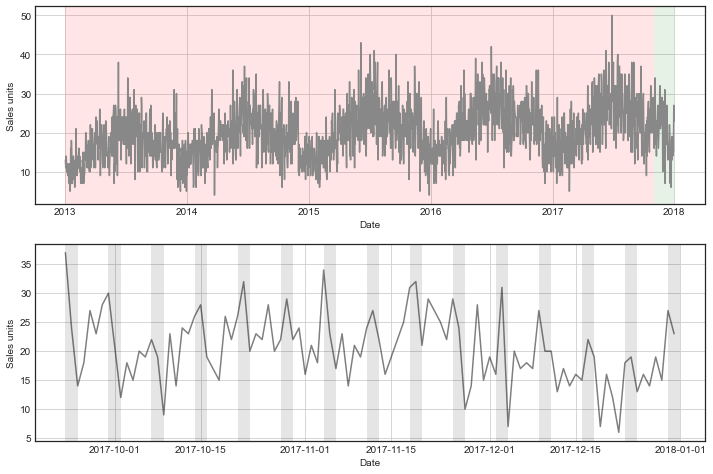

In [6]:
#
# Visualize an example sales series
#
df_one_item = df.query('item == 1 & store == 1').sort_values(["date"], axis=0, ascending=[True])

#
# Set the train/test split date
#
prediction_length = 60
dates = df_one_item.index.unique().sort_values()
split_date = dates[-prediction_length]

#
# Full date range
#
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Sales units')
ax[0].grid(True)
ax[0].axvspan(dates[0], dates[-prediction_length], facecolor='r', alpha=0.1)
ax[0].axvspan(dates[-prediction_length], dates[-1], facecolor='g', alpha=0.1)
ax[0].plot(df_one_item.index, df_one_item['sales'], c='#888888')

#
# Last 100 days
#
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Sales units')
ax[1].plot(df_one_item[-100:].index, df_one_item[-100:]['sales'], c='k', alpha=0.5)
highlight_weekends(ax[1])
ax[1].grid(True)

# NeuralProphet Training and Evaluation

In [ ]:
df_prophet = df_one_item.reset_index()
df_prophet = df_prophet.rename(columns={'date': 'ds', 'sales': 'y'})
df_prophet.drop(columns=['store', 'item'], inplace=True)

df_train, df_test = df_prophet[:-prediction_length], df_prophet[-prediction_length:]

m = NeuralProphet(quantiles=[0.01, 0.10, 0.90, 0.99])
metrics = m.fit(df_train)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.943% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.943% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


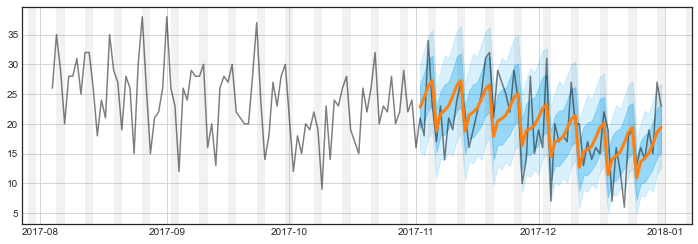

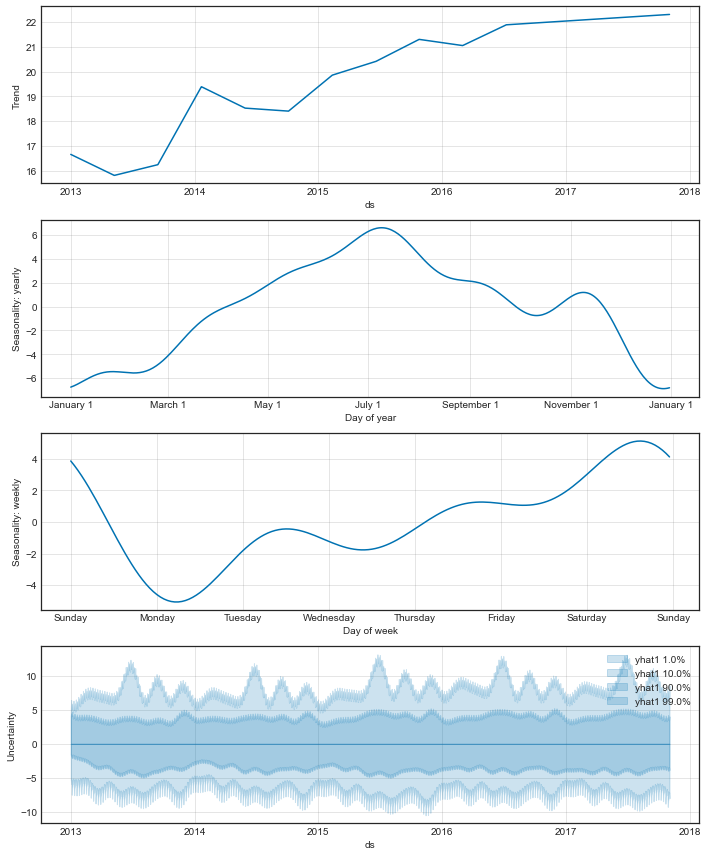

In [18]:
forecast_past = m.predict(df_train)
forecast_future = m.predict(df_test)

fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(df_prophet['ds'][-5 * prediction_length // 2:], df_prophet['y'][-5*prediction_length // 2:], color='k', alpha=0.5)
ax.plot(forecast_future['ds'], forecast_future['yhat1'], color='C1', linewidth=3)
ax.fill_between(forecast_future['ds'], forecast_future['yhat1 10.0%'], forecast_future['yhat1 90.0%'], color='#00a1f1', alpha=0.3)
ax.fill_between(forecast_future['ds'], forecast_future['yhat1 1.0%'], forecast_future['yhat1 99.0%'], color='#00a1f1', alpha=0.15)
ax.grid(True)
highlight_weekends(ax, alpha=0.05)

fig_comp = m.plot_components(forecast_past)